# SEX PREDICTION FROM CLINICAL EXAMINATION

This notebook deals with data exploration, data cleaning, data preprocessing, and model design for the proposed challenge.

## Dependencies

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

from itertools import product

from joblib import dump

import warnings

Since I will be performing several value assignments in slices of Pandas dataframes, I will turn warnings off to curtail visual pollution.

In [2]:
warnings.filterwarnings("ignore")

## Data exploration

### Basic analysis

Loading the data.

In [3]:
df = pd.read_csv('test_data_CANDIDATE.csv', index_col = 0)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,nar,hc,sk,trf
index,,,,,,,,,,,,,,,,,
0,49,M,10000,130,269.0,0,1,163,0,0.0,2.0,0,2,2,0,1,6797.761892
1,61,F,10000,138,166.0,0,0,125,1,3.6,NaN,1,2,2,1,3,4307.686943
2,46,F,10000,140,311.0,0,1,120,1,1.8,NaN,2,3,2,0,1,4118.077502
3,69,F,10000,140,254.0,0,0,146,0,2.0,1.0,3,3,2,1,0,7170.849469
4,51,F,10000,100,222.0,0,1,143,1,1.2,1.0,0,2,2,1,0,5579.040145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,54,F,10000,125,273.0,0,0,152,0,0.5,0.0,1,2,2,2,0,6293.123474
284,42,F,10000,120,240.0,1,1,194,0,0.8,0.0,0,3,2,0,1,3303.841931
285,67,M,10000,106,223.0,0,1,142,0,0.3,NaN,2,2,2,1,0,3383.029119


There are 288 instances of data, described by 17 features, being one of them the target feature (sex).

According to the data documentation, the features are:

> - age: in years
> - sex: (M = male; F = female)
> - cp: chest pain type
> - trestbps: resting blood pressure (in mm Hg on admission to the hospital)
> - chol: serum cholesterol in mg/dl
> - fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
> - restecg: resting electrocardiographic results
> - thalach: maximum heart rate achieved
> - nar: number of arms
> - exang: exercise induced angina (1 = yes; 0 = no)
> - oldpeak: ST depression induced by exercise relative to rest
> - slope: the slope of the peak exercise ST segment
> - hc: patient's hair colour
> - sk: patient's skin colour
> - trf: time spent in traffic daily (in seconds)
> - ca: number of major vessels (0-3) colored by flourosopya
> - thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

Some basic information can be returned using Pandas's built-in methods.

In [4]:
df.describe()

,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,nar,hc,sk,trf
count,288.000000,288.0,288.000000,272.000000,288.000000,288.000000,288.000000,288.000000,288.000000,145.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,54.479167,10000.0,131.315972,245.139706,0.145833,0.531250,149.611111,0.326389,1.049653,1.393103,0.725694,2.302083,1.972222,0.586806,0.940972,4176.658930
std,9.137333,0.0,17.476938,52.985157,0.353553,0.527035,22.782600,0.469708,1.164935,0.604343,1.024661,0.615476,0.219103,0.651532,1.001735,1988.789872
min,29.000000,10000.0,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,653.415425
25%,47.000000,10000.0,120.000000,208.000000,0.000000,0.000000,133.750000,0.000000,0.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,2671.229092
50%,56.000000,10000.0,130.000000,239.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,2.000000,0.000000,1.000000,4222.567419
75%,61.000000,10000.0,140.000000,273.250000,0.000000,1.000000,166.250000,1.000000,1.600000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,5885.708843
max,77.000000,10000.0,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,2.000000,2.000000,3.000000,7389.481550


This method returns distribution statistics on the numerical features. Some insights:

- Some categorical features are being treated as numerical, but the quantile information returned above might help to find some potential inconsistency in those data. I found nothing of the sort.
- No negative values, which was expected for these features.
- The binary features are also consistent.
- `cp` has no standard deviation, which means all values are equal. Features like that are not useful in a classification model, therefore I decide here to drop this one.
- I found nothing abnormal with the numerical features that are familiar to me. `age`, `trestbps`, `chol` and `trf` are within reasonable bounds, this last one considering that a day is 84,600 seconds long. `thalach` does also seem fine; even though 71 bpm might be low to a 'maximum heart rate', I will by now just keep that in mind for further analysis.
- First I suspected that `slope`, being a measure of, well, slope, should be continuous, but some research told me that it is usually reported as 'flat', 'upsloping' or 'downsloping', which conforms to the values reported, 0, 1 or 2. Therefore, it should be treated as categorical.
- The maximum value for `ca` is 4, but both from the documentation and research I found that it should be 3.
- `thal` is also documented as a value of 3, 6 or 7, but that is not the case.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 0 to 287
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       288 non-null    int64  
 1   sex       288 non-null    object 
 2   cp        288 non-null    int64  
 3   trestbps  288 non-null    int64  
 4   chol      272 non-null    float64
 5   fbs       288 non-null    int64  
 6   restecg   288 non-null    int64  
 7   thalach   288 non-null    int64  
 8   exang     288 non-null    int64  
 9   oldpeak   288 non-null    float64
 10  slope     145 non-null    float64
 11  ca        288 non-null    int64  
 12  thal      288 non-null    int64  
 13  nar       288 non-null    int64  
 14  hc        288 non-null    int64  
 15  sk        288 non-null    int64  
 16  trf       288 non-null    float64
dtypes: float64(4), int64(12), object(1)
memory usage: 40.5+ KB


The main information here is that `chol` and `slope` have missing values; `slope` is missing around 50% of instances.

Now I will check how many instances are there for each target class.

In [6]:
df['sex'].value_counts()

F    194
M     91
f      2
m      1
Name: sex, dtype: int64

This showed me that this feature is inconsistently reported. I will standardize that sex should be given in uppercase.

In [7]:
df['sex'] = df['sex'].map(lambda x: x.upper())

Then let me check the counts again, but expressed as proportion.

In [8]:
df['sex'].value_counts(normalize = True)

F    0.680556
M    0.319444
Name: sex, dtype: float64

This reveals that the dataset in unbalanced, being females the majority. This in turns tells me that, first, I must consider the unbalance for splitting strategies and, potentially, evaluation metrics. Second, the proportion values indicates that the baseline accuracy of the simplest model is 68%, so any other model should outperform this.

### Analysis of numerical and categorical features

Now I will check some distribution plots for the features, according to their numerical or categorical nature.

*Defining a function to plot a histogram and a boxplot for the numerical features*

This analysis will drop missing values - I know already that only `chol` applies -, then split the data by sex, and plot both subsets separately. The histogram will report densities, not counts, to account for the unbalance in sex counts.

In [9]:
def plot_stats_numerical(feature):
    df_temp = df[feature].dropna()
    df_temp_M = df_temp[df.sex == 'M']
    df_temp_F = df_temp[df.sex == 'F']
    fig, ax = plt.subplots(1, 2)
    fig.suptitle(feature)
    ax[0].hist(df_temp_M, density = True, alpha = 0.5, label = 'M', color = 'blue')
    ax[0].hist(df_temp_F, density = True, alpha = 0.5, label = 'F', color = 'red')
    ax[0].legend()
    ax[1].boxplot([df_temp_M, df_temp_F], labels = ['M', 'F'])
    plt.show()

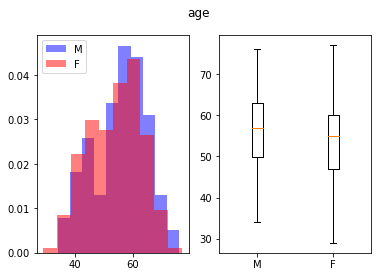

In [10]:
plot_stats_numerical('age')

The age distributions are very similar. The age span for females is a little broader in the young side, but that might be due to the larger female cohort.

I did wonder if age was a useful sex predictor, and decided in that favor based on two reasons: females tend to live longer, and the distribution plots show that there is some difference in this population. If the model is to be applied to this same population, age is expected to be helpful.

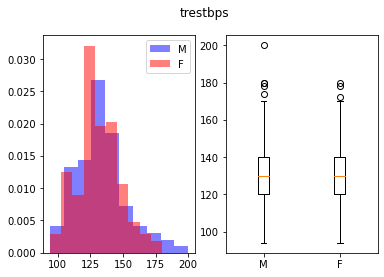

In [11]:
plot_stats_numerical('trestbps')

The distributions are again very similar, including the medians. Males have a few more outliers, with one farther off. The ten largest values in the male subset are given below. The largest value does seem to be atypical.

In [12]:
sorted(df['trestbps'][df.sex == "M"])[::-1][:10]

[200, 180, 180, 178, 174, 170, 160, 160, 160, 160]

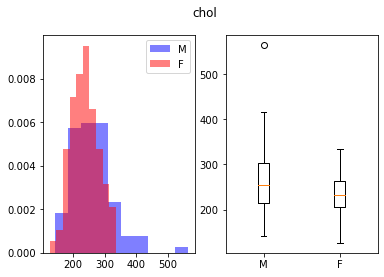

In [13]:
plot_stats_numerical('chol')

The male distribution is more spread, with one pronounced outlier. The male median is also higher. 

Checking the ten largest male values, and confirming the presence of a single outlier.

In [14]:
sorted(df['chol'].dropna()[df.sex == "M"])[::-1][:10]

[564.0, 417.0, 409.0, 407.0, 394.0, 360.0, 354.0, 342.0, 341.0, 340.0]

Since there are missing values in `chol`, let me check its segmentation by sex.

In [15]:
df['sex'][df.chol.isna()].value_counts()

F    15
M     1
Name: sex, dtype: int64

Interestingly, 15 from the 16 missing values are from females. If I knew that the final model would be applied to predict sex from new datasets that might also be incomplete, I would be willing to create a new feature to inform the model if `chol` is missing, as it seems to be very informative of the sex of the individual. In the current case, though, I will assume new datasets are complete for this feature, and not use this information.

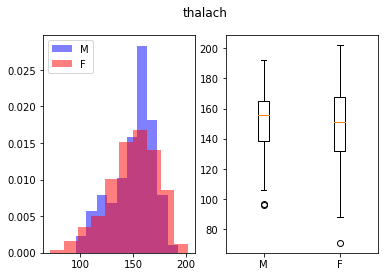

In [16]:
plot_stats_numerical('thalach')

The female distribution is more spread. Both sexes have a few outliers. Here I become a little suspicious of the 71 bpm heartrate reported for one female, as it is a sole outlier.

Smallest values for the male and female groups:

In [17]:
print('MALE:', sorted(df['thalach'][df.sex == "M"])[:10], '\nFEMALE:', sorted(df['thalach'][df.sex == "F"])[:10])

MALE: [96, 97, 106, 114, 114, 115, 115, 116, 117, 121] 
FEMALE: [71, 88, 90, 95, 96, 99, 103, 105, 105, 105]


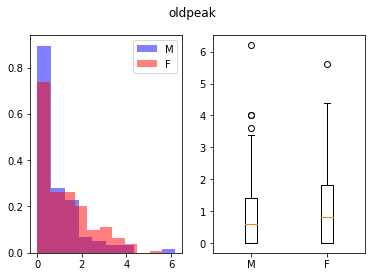

In [18]:
plot_stats_numerical('oldpeak')

Again the female distribution is more spread, showing also a slightly larger median. Outliers are present on both groups.

In [19]:
print('MALE:', sorted(df['oldpeak'][df.sex == "M"])[::-1][:10], '\nFEMALE:', sorted(df['oldpeak'][df.sex == "F"])[::-1][:10])

MALE: [6.2, 4.0, 4.0, 3.6, 3.4, 3.0, 2.8, 2.6, 2.0, 2.0] 
FEMALE: [5.6, 4.4, 4.2, 4.2, 4.0, 3.8, 3.6, 3.6, 3.6, 3.5]


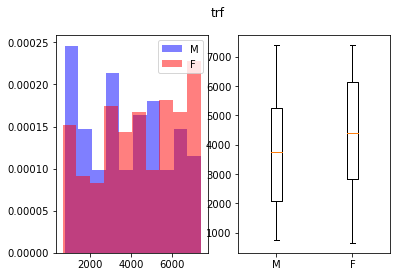

In [20]:
plot_stats_numerical('trf')

The lower and upper bounds of both distributions are practically equal, and in general they seem to be somewhat uniformly distributed, but the female distribution is slightly skewed to the right.

*Defining a function to plot a barplot of the categorical features*

Here I am choosing to keep missing values - again, I know only `slope` is the case -, because I can analyze them as a single category. As with the numerical features, I am also normalizing the data to report proportions instead of absolute counts.

In [21]:
def plot_stats_categorical(feature):
    df_temp = df.groupby('sex')[feature].value_counts(normalize = True, dropna = False).rename('proportion').reset_index()
    df_temp[feature][df_temp[feature].isna()] = 'NA'
    sns.barplot(x = 'sex', y = 'proportion', hue = feature, data = df_temp)
    plt.title(feature)
    plt.show()

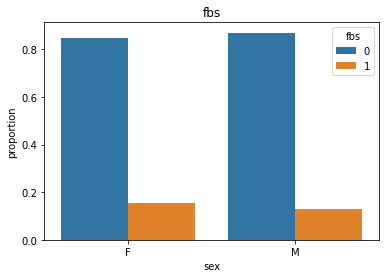

In [22]:
plot_stats_categorical('fbs')

The difference is minimal, I would assume this feature is not helpful in the classification task.

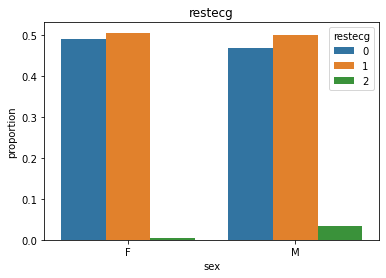

In [23]:
plot_stats_categorical('restecg')

There is a small relative difference in class 0, and a larger relative difference in class 2.

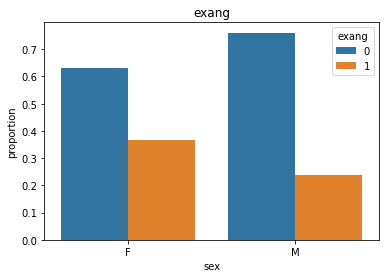

In [24]:
plot_stats_categorical('exang')

Males have a larger proportion of individuals on class 0.

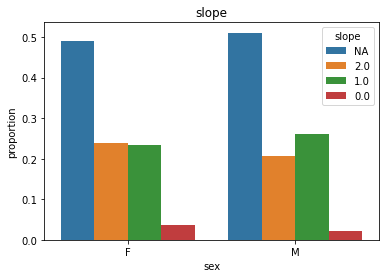

In [25]:
plot_stats_categorical('slope')

There are differences in all three classes, but the proportion of missing values is quite high, surpassing 50% in the case of males.

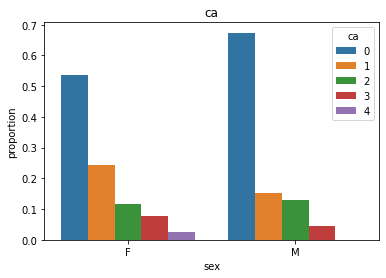

In [26]:
plot_stats_categorical('ca')

The profiles are quite different. Let me check how many individuals have the abnormal value of 4.

In [27]:
df.groupby('sex')['ca'].value_counts()

sex  ca
F    0     105
     1      48
     2      23
     3      15
     4       5
M    0      62
     1      14
     2      12
     3       4
Name: ca, dtype: int64

5 females. That is quite intriguing, since, if this was a typo for example, I would not expect it to be present in more than a few cases.

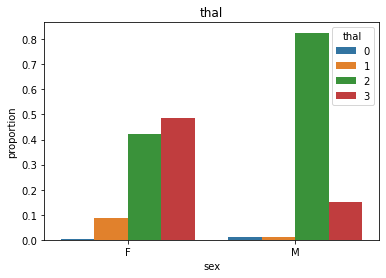

In [28]:
plot_stats_categorical('thal')

This seems to be the categorical feature with the largest differences between sexes. Nonetheless, once again there is a conflict with the documentation, according which this feature should have values of 3, 6 or 7, relating to three possible categories.

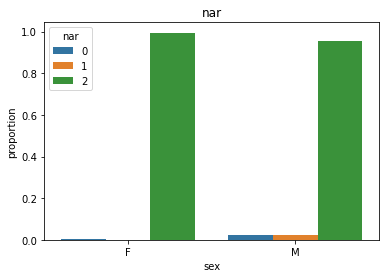

In [29]:
plot_stats_categorical('nar')

Most people have 2 arms (hooray!), but the proportion of one-armed and armless men is larger. I suspect this is because men are usually more involved with dangerous activities.

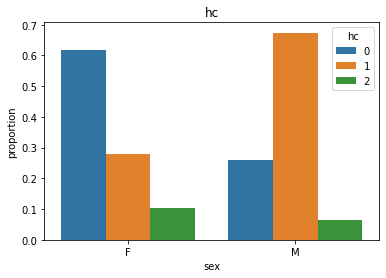

In [30]:
plot_stats_categorical('hc')

I found this very striking, I would not suspect such a large difference in hair color. I suspect this is a characteristic of the community from which these individuals were gathered, or dyed hair color is being reported, and females tend to dye their hair more often.

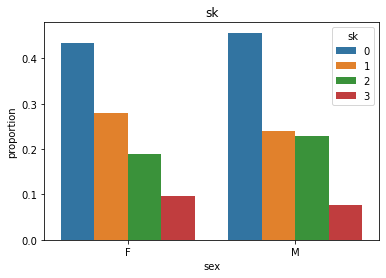

In [31]:
plot_stats_categorical('sk')

Not such a large difference as in hair color, yet the profiles are different enough to aid a classification model. This quite surely reflects the underlying community.

## Data cleaning

First off, since there are not many data instances, I will avoid dropping values, choosing instead to impute or correct them when necessary.

Creating a copy of the original dataframe for the cleaning procedure.

In [32]:
df_clean = df.copy()

### Numerical features

The numerical features present two issues worth considering: outliers (from several) and missing values (from `chol`).

#### Outliers

First off, I will consider outliers those values shown as such in the boxplots. 

I can deal with outliers with two approaches: I can consider them to be natural deviations from the underlying distribution (occasionally even creating a new feature identifying the outliers), and keep them as such, or I can consider them to be anomalous data, and correct them. The decision shoud rely on proper research on each of the features, but given the time constraint, I will apply some common sense. 

The outliers will be dealt with in a case-by-case fashion.

`trestbps`: I believe some outliers to be expected, as 'high blood pressure' is a common situation. Nonetheless, one value in the male cohort is quite extreme. I will cap this feature to the second largest value in the male group, as even if not the best solution, this will not affect much the underlying distribution.

In [33]:
df_clean['trestbps'][np.argmax(df_clean['trestbps'])] = sorted(df_clean['trestbps'][df_clean.sex == 'M'])[::-1][1]

`chol`: The one outlier seems to be erroneous, therefore I will also cap this variable the same way I did above.

In [34]:
df_clean['chol'][np.argmax(df_clean['chol'])] = sorted(df_clean['chol'][df_clean.sex == 'M'])[::-1][1]

`thalach`: There are two outliers in the male group, but they have approximately the same value, which points to their veracity, therefore I choose to keep them. The outlier in the female group is both more extreme and solitary, so I will cap it to the second lowest value in this group.

In [35]:
df_clean['thalach'][np.argmin(df_clean['thalach'])] = sorted(df_clean['chol'][df_clean.sex == 'F'])[1]

`oldpeak`: Both groups have outliers, but the female group is right skewed to begin with, therefore I will let it be. The largest value in the male group will be capped as above.

In [36]:
df_clean['oldpeak'][np.argmax(df_clean['oldpeak'])] = sorted(df_clean['oldpeak'][df_clean.sex == 'M'])[::-1][1]

#### Missing values

The missing values in `chol` will be imputed with the average within each group.

In [37]:
chol_avg_M = df[df.sex == 'M']['chol'].mean()
chol_avg_F = df[df.sex == 'F']['chol'].mean()

chol_avg_M, chol_avg_F

(262.45054945054943, 236.4364640883978)

In [38]:
df_clean['chol'][df_clean.sex == 'M'] = df_clean['chol'][df_clean.sex == 'M'].fillna(chol_avg_M)
df_clean['chol'][df_clean.sex == 'F'] = df_clean['chol'][df_clean.sex == 'F'].fillna(chol_avg_F)

---
I will now instantiate a list with the names of the numerical features that I will be using in model design, which will be helpful later.

In [39]:
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'trf']

### Categorical features

Most of these features deserve no commentary, with those with the largest difference in sex profile possibly aiding a classification model more. I will keep `fbs`, despite its apparent unimportance, because it may help to resolve ties. 

Additional comments on:

`slope`: despite the large proportion of missing values, I will keep it with a 'missing' category, as the other values are potentially useful.

In [40]:
df_clean['slope'] = df_clean['slope'].fillna('missing')

`ca`: The value 4 does not conform the documentation nor the research on this feature. Nonetheless, there is a very similar feature called 'number of major vessels with >50% narrowing', which accepts the value 4. Given the similarity in name, and that there are 5 instances of this value, I will let this feature in.

`thal`: The reported values have no clear relationship with the documentation. Even though the frequency plot suggests that it is useful for this classification task, I have no reason to believe that this feature is not spurious. It breaks my heart, but I will drop it.

`hc` and `sk`: A priori, I would drop these features as irrelevant, as there is no reason to assume a relationship between hair or skin color and sex, but given the differences described above, I will assume that the population analyzed is efficiently described by these features, and keep them.

---
Instantiating a list with the names of the categorical features to be brought along to model design:

In [41]:
categorical = ['fbs', 'restecg', 'exang', 'slope', 'ca', 'nar', 'hc', 'sk']

## Data preprocessing

Now that the the dataset is clean and trimmed, I will split it into the numerical and categorical features for the corresponding preprocessing.

In [42]:
df_clean_numerical = df_clean[numerical]
df_clean_categorical = df_clean[categorical]

### Numerical features

These features should be scaled to eliminate the effect of order of magnitude. Since the categorical features will be expressed as 0 or 1, I will chose the MinMaxScaler method.

In [43]:
scaler = MinMaxScaler()
df_clean_numerical_values = scaler.fit_transform(df_clean_numerical)

### Categorical features

First, some of these features are expressed as integers, I need to convert them to strings.

In [44]:
df_clean_categorical = df_clean_categorical.applymap(str)

Now I will transform this dataframe to its one-hot encoded version.

In [45]:
encoder = OneHotEncoder()
df_clean_categorical_values = np.asarray(encoder.fit_transform(df_clean_categorical).todense())

### Bringing them back together

I now can concatenate them all in a single array.

In [46]:
X = np.concatenate([df_clean_numerical_values, df_clean_categorical_values], axis = 1)
X.shape

(288, 32)

The resulting array has all 288 instances of data, now presented as 32 features.

I will also keep the target feature in a new variable.

In [47]:
y = df_clean['sex'].values

## Model design

### Model type

I will first fit five types of model to the data, covering different mathematical bases: two linear models (logistic regression and SVM), two decision trees (standard decision tree and a gradient boosting classifier), and one neural network. All models will be implemented with the Scikit-Learn package, initially with standard parameters. My aim here is to find out if any model type is particularly efficient for this classification task.

The models will be evaluated based on their accuracy, and the evaluation approach will be that of using 10 folds in a cross-validation fashion.

Here I am implementing a stratified splitting strategy to deal with the unbalanced dataset.

In [48]:
splitter = StratifiedKFold(n_splits = 10, random_state = 42)

models = {
    'LR': LogisticRegression(),
    'SVC': SVC(),
    'DecisionTree': DecisionTreeClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'NeuralNetwork': MLPClassifier()
}

results_df = pd.DataFrame([])
for i, (model_name, model) in enumerate(models.items()):
    
    np.random.seed(42)
    
    results = cross_val_score(model, X, y, cv = splitter)
    
    results_model = pd.DataFrame({
        'model': model_name,
        'mean_accuracy': results.mean(),
        'std_accuracy': results.std()
    }, index = [i])
    
    results_df = results_df.append(results_model)

In [49]:
results_df.sort_values('mean_accuracy', ascending = False)

,model,mean_accuracy,std_accuracy
0,LR,0.725616,0.076444
4,NeuralNetwork,0.722414,0.045092
1,SVC,0.718842,0.056037
3,GradientBoosting,0.687192,0.051395
2,DecisionTree,0.649754,0.077702


The best model in this first investigation is a Logistic Regression, followed closely by a Neural Network and a classifier based on Support Vector Machines. The models based on trees were equal to or worse than the baseline.

My first approach was to tune further the Neural Network, since it is quite as accurate as the Logistic Regression, but the smaller standard deviation tells me it is more generalizable. However, the performance did not improve with tuning iterations, and its final accuracy was practically the same as the baseline. So I turned to my second choice.

For this challenge, I prefer SVC over LR, for two main reasons: the accuracy is not 1% lower while the standard deviation is 2% lower, and SVMs have some interesting parameters, like the kernel trick, that might improve the model in unexpected ways. Therefore, I decided to work further on refining this classifier.

### Feature selection

Now, I will check if using less than all features might be helpful. For this step, I will first classify the features according to their relative importance, as determined by an Extra Trees Classifier.

In [50]:
tree = ExtraTreesClassifier(random_state = 42)
tree.fit(X, y)
importance = tree.feature_importances_
argsort = np.argsort(importance)[::-1]
importance = importance[argsort]

The object `argsort` contains the index of the features ordered decreasingly according to their importances.

Sometimes it is useful to inspect what those features are:

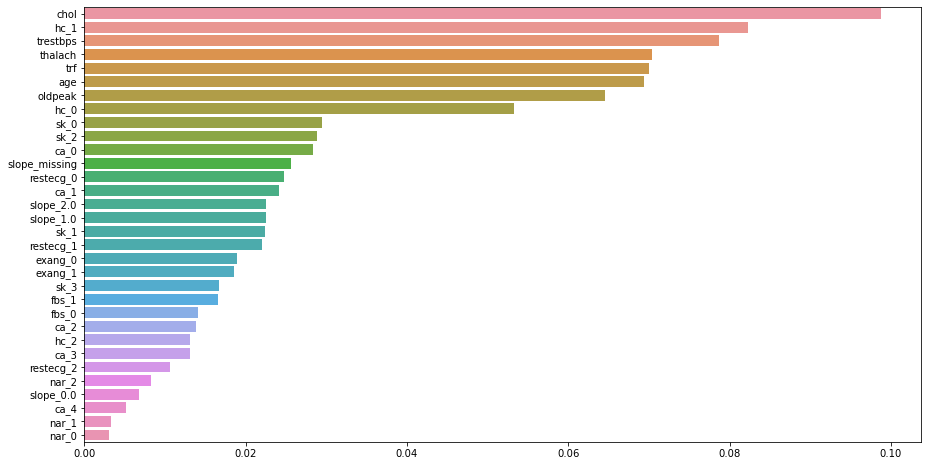

In [51]:
# Retrieving the categorical features names (after one hot encoding)

cat_features_names = [list(product([cat], cat_name)) for cat, cat_name in zip(categorical, encoder.categories_)]
cat_features_names = [val for sublist in cat_features_names for val in sublist]
cat_features_names = ['_'.join(x) for x in cat_features_names]

# Concatenating numerical and categorical features names

features_names = np.asarray(numerical + cat_features_names)

# Ordering features names according to their importance

features_names_sorted = list(features_names[argsort])

# Plotting

plt.figure(figsize = (15, 8));
sns.barplot(x = importance, y = features_names_sorted);

`chol` is the most important feature, having around 9% of the overall discriminative power, followed by one category of `hc`, then several numerical features: `trestbps`, `thalach`, `trf`, `age` and `oldpeak`. The features lose discriminative power pronouncedly after `oldpeak`. `nar` is a very weak predictor, I suspect that is because the majority of people have 2 arms regardless of sex.

Now that the features are ordered, I will pick from 1 to all ordered features to fit the SVC model again.

In [52]:
results_df = pd.DataFrame([])
for i in range(1, len(argsort) + 1):
    X_sel = X[:, argsort[:i]]
    model = SVC()
    
    results = cross_val_score(model, X_sel, y, cv = splitter)
    
    results_model = pd.DataFrame({
        'num_feats': i,
        'mean_accuracy': results.mean(),
        'std_accuracy': results.std()
    }, index = [i - 1])
    
    results_df = results_df.append(results_model)

Visualizing the top 5 models and the performance evolution.

In [53]:
results_df.sort_values('mean_accuracy', ascending = False).head()

,num_feats,mean_accuracy,std_accuracy
12,13,0.743227,0.063562
11,12,0.736207,0.059771
13,14,0.736207,0.059771
10,11,0.736084,0.066091
17,18,0.725739,0.072842


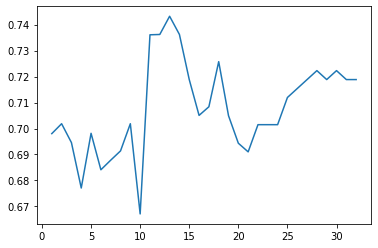

In [54]:
plt.plot(results_df['num_feats'], results_df['mean_accuracy'])

The inclusion of few features, even whether the most important, helps little. The performance increases with 11 features than peaks at 13. More features make it lose accuracy. This behavior might be due to the fact that some features are correlated, and SVMs assume feature independence, do not taking feature interactions in consideration. The addition of more features, then, might destabilize its predictive capacity. Also, it might be that the additional features add more noise than signal, muddling more than helping.

For this challenge, I will stick to 13 features, which has the best accuracy while a marginally larger standard deviation than the second place.

In [55]:
X = X[:, argsort[:13]]

### Model tuning

It is time to tweak the model parameters. I will perform an exhaustive search in the solution space, changing some of the parameters the model accepts around the standard values used so far. The results will be based on the same cross validation strategy used before (10 folds, stratified splitting).

In [56]:
params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto']
}

model = SVC()

grid_search = GridSearchCV(model, params, cv = splitter, n_jobs = 2)
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
             estimator=SVC(), n_jobs=2,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4, 5],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

Inspecting the best parameters and the best score:

In [57]:
print(grid_search.best_params_, ':', grid_search.best_score_)

{'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'} : 0.7465517241379309


The performance improved a bit. The parameter `degree` does not apply to `kernel` rbf, therefore it can be overlooked. I will try a second run of tuning choosing values for `C` around the best value found so far.

In [58]:
params = {
    'C': np.arange(0.5, 20.1, 0.5),
    'kernel': ['rbf'],
    'gamma': ['auto']
}

model = SVC()

grid_search = GridSearchCV(model, params, cv = splitter, n_jobs = 2)
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
             estimator=SVC(), n_jobs=2,
             param_grid={'C': array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5,
       17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ]),
                         'gamma': ['auto'], 'kernel': ['rbf']})

In [59]:
print(grid_search.best_params_, ':', grid_search.best_score_)

{'C': 8.5, 'gamma': 'auto', 'kernel': 'rbf'} : 0.75


The performance improved a little further.

### Model training and evaluation

At this step, I will use the parameters found above in fine tuning to fit the final model using the whole dataset.

First, I will set aside 10% of the data in a test set to report how well the model is performing.

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42, stratify = y)

In [61]:
model =  SVC(**grid_search.best_params_)
model.fit(X_train, y_train)

SVC(C=8.5, gamma='auto')

In [62]:
model.score(X_test, y_test)

0.7241379310344828

In [63]:
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[17,  3],
       [ 5,  4]], dtype=int64)

## Conclusion

The final evaluation shows an accuracy of 72.4% for this particular split. The result is not impressive, especially given the 68% baseline, but I suppose that it is quite difficult to classify sex based on the features given and chosen to train the model. 17 out of 20 females (85%), and 5 out of 9 males (55%), where correctly classified.

## Potential improvements

If I were asked to improve this model, these are some of the steps that I would follow:
- research the literature on the features: to better understand their nature and typical values, and then choose more properly values to drop or to correct;
- consult the data provider: to make sure that the features that conflict with the documentation are correctly dealt with, and eventually request if other features would also be available for this population;
- try other scalers to scale the numerical features: each scaler is built under certain premisses regarding the underlying data distribution, and I did not investigate them deeper, I actually suspect there is not enough data to derive strong evidence on the data distributions.
- try other algorithms to determine feature importance: they also bring some assumptions that I cannot unambiguously rely on, so other methods could deliver better performance;
- tune the model changing the preprocessing methods: besides the two points commented above, the number of features selected, for instance, does not have a direct relationship with some parameters of the model, and a more thorough investigation could benefit from optimizing all of them alongside;
- tune other model types: it might be that, after tuning, a model that was not performing that well takes a lead over the others;
- tune other model parameters: every model allows several parameters to be tweaked, and this investigation could also be deeper;
- use other libraries: models like decision trees and neurals networks have dedicated libraries like XGBoost, TensorFlow and PyTorch that allow more sofisticated architectures and implementations, which permit a finer tuning process.

## Saving objects for production

At last, I will gather all objects that transform data, that were parameterized based on the given dataset, into a dictionary, then save it to disk, to that I can retrieve them in a production setup to transform new incoming data.

In [64]:
save_objects = {
    # The scaler used to scale numerical features
    'scaler': scaler,
    # The encoder used to hot encode categorical features
    'one_hot_encoder': encoder,
    # The argsort list that contains the index for the 13 most important features
    'argsort': argsort[:13],
    # The trained model
    'model': model
}

dump(save_objects, 'save_objects.joblib')

['save_objects.joblib']

This ends this phase of the model development.